### Standford Cars Vehicle Recognition - CNN modeling ROUGH DRAFT

### CODE ONLY, For a detailed report, please refer to the Final Report

#### by Sean Sungil Kim

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# importing necessary modules
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import keras
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings("ignore")

# custom python scripts
import SC_sungil             # preprocessing
import ConvNet_sungil         # ConvNet modeling

Using TensorFlow backend.


In [3]:
# for convenience, vehicle detected images are already saved
# loading the pre-saved vehicle detected images, classes and labels
train_detected_sc, train_data_class, data_labels = SC_sungil.load_images('saved_images/training/',\
                                            'devkit/cars_train_annos.mat', None, 'devkit/cars_meta.mat')
test_detected_sc, test_data_class = SC_sungil.load_images('saved_images/testing/', None,\
                                                          'devkit/cars_test_annos_withlabels', None)

Training image loading runtime: 206.48489785194397
Testing image loading runtime: 260.1206569671631


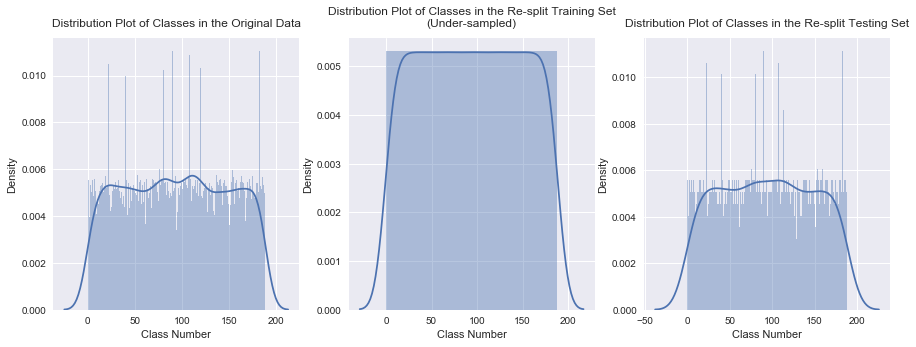

Total of 7938 images in the training data
Total of 1985 images in the testing data
80.00 percent training set, 20.00 percent testing set


In [4]:
# combining the training and testing dataset
all_data = np.concatenate((train_detected_sc, test_detected_sc), axis = 0)
all_class = np.concatenate((train_data_class, test_data_class), axis = 0)

# removing year and mergining classes
new_data_labels, all_class = SC_sungil.rmv_year(data_labels, all_class)
all_class = all_class - 1

# number of classes
num_classes = len(new_data_labels)

# 80% train 20% test split
# test_size was set to 0.1226, to maintain the validation set size to 20% post under-sampling
x_train, x_test, y_train, y_test = train_test_split(all_data, all_class, stratify = all_class,\
                                                    test_size = 0.1226)

# random under-sampling
und_x_train, und_y_train = SC_sungil.under_sample(x_train, y_train)

# converting a class vector to binary class matrix
y_train_bin = keras.utils.to_categorical(und_y_train, num_classes)
y_test_bin = keras.utils.to_categorical(y_test, num_classes)

# post split class distribution
fig = plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.distplot(all_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Original Data', y = 1.02)
plt.xlabel('Class Number'), plt.ylabel('Density')
plt.subplot(1, 3, 2)
sns.distplot(und_y_train, bins = num_classes)
plt.title('Distribution Plot of Classes in the Re-split Training Set\n(Under-sampled)', y = 1.02)
plt.xlabel('Class Number'), plt.ylabel('Density')
plt.subplot(1, 3, 3)
sns.distplot(y_test, bins = num_classes)
plt.title('Distribution Plot of Classes in the Re-split Testing Set', y = 1.02)
plt.xlabel('Class Number'), plt.ylabel('Density')
plt.show()

tot_len = len(und_x_train) + len(x_test)
print('Total of %i images in the training data' % len(und_x_train))
print('Total of %i images in the testing data' % len(x_test))
print('%0.2f percent training set, %0.2f percent testing set' \
      % (len(und_x_train)/tot_len*100, len(x_test)/tot_len*100))

In [5]:
# obtaining the average image size, list of width sizes and list of height sizes
train_avg_size, train_x_size_List, train_y_size_List, train_aspect_ratio_List = SC_sungil.avg_size(und_x_train)
test_avg_size, test_x_size_List, test_y_size_List, test_aspect_ratio_List = SC_sungil.avg_size(x_test)

# utilizing the mean training aspect ratio for resizing, width size is set to 100
resized_x_train = SC_sungil.resize_all(und_x_train, size = (100, \
                                       int(round(100/np.mean(train_aspect_ratio_List), 0))))
resized_x_test = SC_sungil.resize_all(x_test, size = (100, \
                                      int(round(100/np.mean(train_aspect_ratio_List), 0))))

# normalizing data, RGB/grayscale images are out of 255
norm_x_train = resized_x_train / 255.0
norm_x_test = resized_x_test / 255.0

Data resizing runtime: 350.9280481338501
Data resizing runtime: 104.12126612663269


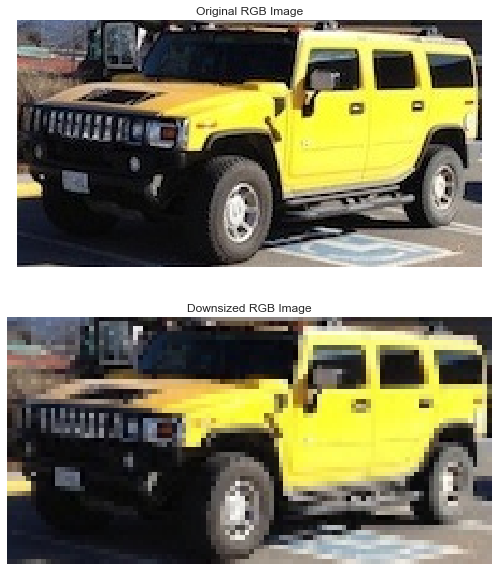

In [6]:
# original and downsized comparison
plt.figure(figsize = (12, 10))
plt.subplot(2, 1, 1), plt.xticks([]), plt.yticks([]), plt.grid(False)
plt.imshow(cv2.cvtColor(und_x_train[0], cv2.COLOR_BGR2RGB)), plt.title('Original RGB Image')
plt.subplot(2, 1, 2), plt.xticks([]), plt.yticks([]), plt.grid(False)
plt.imshow(cv2.cvtColor(resized_x_train[0], cv2.COLOR_BGR2RGB)), plt.title('Downsized RGB Image')
plt.show()

### Exploring with ConvNet Architectures

#### Extra-Small (Conv-Conv-Pool-Dropout)

In [7]:
model1 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = norm_x_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.3),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder1 = ConvNet_sungil.lr_finder(model1)
lr_finder1.find(norm_x_train, y_train_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
7938/7938 [==============================] - 300s 38ms/step - loss: 5.2604 - acc: 0.0054
Epoch 2/10
7938/7938 [==============================] - 308s 39ms/step - loss: 5.1970 - acc: 0.0131
Epoch 3/10
7938/7938 [==============================] - 308s 39ms/step - loss: 5.0012 - acc: 0.0310
Epoch 4/10
7938/7938 [==============================] - 308s 39ms/step - loss: 4.4596 - acc: 0.0985
Epoch 5/10
7938/7938 [==============================] - 307s 39ms/step - loss: 3.9671 - acc: 0.1636
Epoch 6/10
7938/7938 [==============================] - 311s 39ms/step - loss: 3.9395 - acc: 0.1832
Epoch 7/10
7938/7938 [==============================] - 310s 39ms/step - loss: 5.2862 - acc: 0.0060
Epoch 8/10
7938/7938 [==============================] - 312s 39ms/step - loss: 5.2800 - acc: 0.0042
Epoch 9/10
7938/7938 [==============================] - 315s 40ms/step - loss: 5.3344 - acc: 0.0042
Epoch 10/10
7938/7938 [==============================] - 321s 40ms/step - loss: 5.4613 - acc: 0.0052

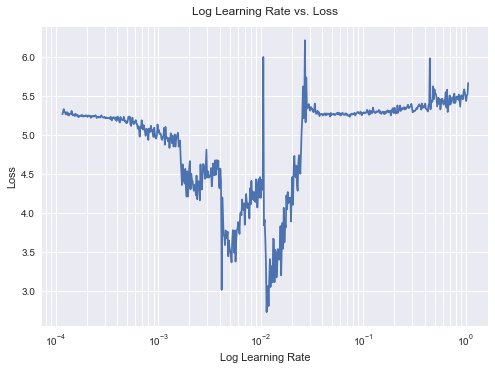

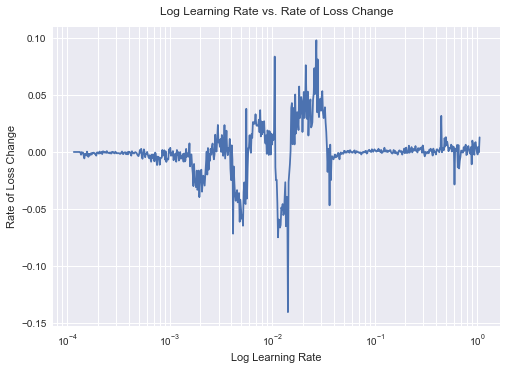

In [8]:
lr_finder1.plot_loss()
lr_finder1.plot_loss_change(sma = 20)

In [9]:
K.set_value(model1.optimizer.lr, 1.1*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model1.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history1 = model1.fit(norm_x_train, y_train_bin, batch_size = 128, epochs = 200,\
                      validation_data = (norm_x_test, y_test_bin), callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 7938 samples, validate on 1985 samples
Epoch 1/200
7938/7938 [==============================] - 334s 42ms/step - loss: 5.2643 - acc: 0.0077 - val_loss: 5.1330 - val_acc: 0.0126

Epoch 00001: val_acc improved from -inf to 0.01259, saving model to best_model1.h5
Epoch 2/200
7938/7938 [==============================] - 298s 38ms/step - loss: 5.0452 - acc: 0.0242 - val_loss: 4.9813 - val_acc: 0.0287

Epoch 00002: val_acc improved from 0.01259 to 0.02872, saving model to best_model1.h5
Epoch 3/200
7938/7938 [==============================] - 330s 42ms/step - loss: 4.5121 - acc: 0.0843 - val_loss: 4.6309 - val_acc: 0.0610

Epoch 00003: val_acc improved from 0.02872 to 0.06096, saving model to best_model1.h5
Epoch 4/200
7938/7938 [==============================] - 337s 42ms/step - loss: 3.2760 - acc: 0.2764 - val_loss: 4.5027 - val_acc: 0.0877

Epoch 00004: val_acc improved from 0.06096 to 0.08766, saving model to best_model1.h5
Epoch 5/200
7938/7938 [==============================] 

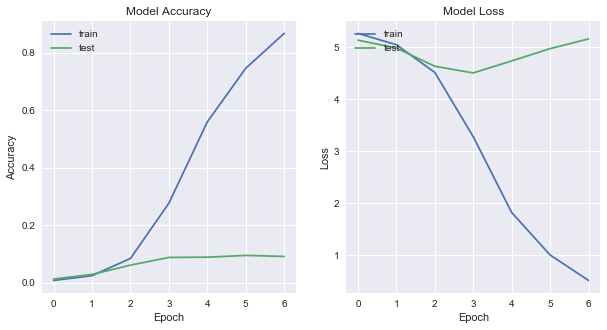

In [10]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['acc']), plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss']), plt.plot(history1.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Small (Conv-Conv-Pool-Conv-Conv-Pool-Dropout)

In [11]:
model2 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = norm_x_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.30),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder2 = ConvNet_sungil.lr_finder(model2)
lr_finder2.find(norm_x_train, y_train_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
7938/7938 [==============================] - 344s 43ms/step - loss: 5.2423 - acc: 0.0057
Epoch 2/10
7938/7938 [==============================] - 341s 43ms/step - loss: 5.1803 - acc: 0.0088
Epoch 3/10
7938/7938 [==============================] - 332s 42ms/step - loss: 5.1038 - acc: 0.0171
Epoch 4/10
7938/7938 [==============================] - 336s 42ms/step - loss: 4.9910 - acc: 0.0306
Epoch 5/10
7938/7938 [==============================] - 331s 42ms/step - loss: 4.9319 - acc: 0.0380
Epoch 6/10
7938/7938 [==============================] - 331s 42ms/step - loss: 5.2568 - acc: 0.0044
Epoch 7/10
7938/7938 [==============================] - 328s 41ms/step - loss: 5.2572 - acc: 0.0055
Epoch 8/10
7938/7938 [==============================] - 333s 42ms/step - loss: 5.2771 - acc: 0.0053
Epoch 9/10
7938/7938 [==============================] - 326s 41ms/step - loss: 5.3366 - acc: 0.0054
Epoch 10/10
7938/7938 [==============================] - 330s 42ms/step - loss: 5.4697 - acc: 0.0055

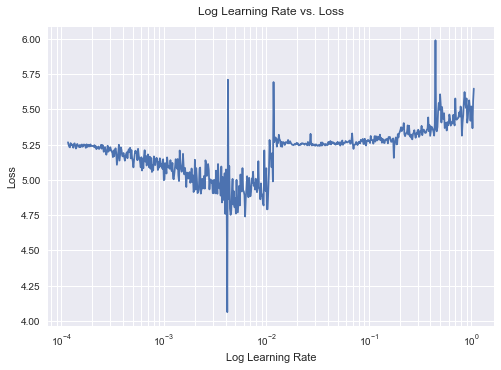

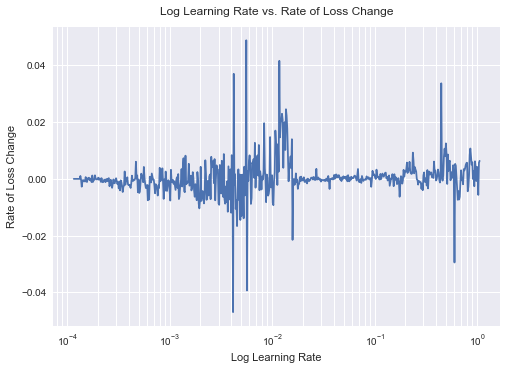

In [12]:
lr_finder2.plot_loss()
lr_finder2.plot_loss_change(sma = 20)

In [13]:
K.set_value(model2.optimizer.lr, 5*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model2.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history2 = model2.fit(norm_x_train, y_train_bin, batch_size = 128, epochs = 200,\
                      validation_data = (norm_x_test, y_test_bin),  callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 7938 samples, validate on 1985 samples
Epoch 1/200
7938/7938 [==============================] - 340s 43ms/step - loss: 5.2548 - acc: 0.0037 - val_loss: 5.2420 - val_acc: 0.0045

Epoch 00001: val_acc improved from -inf to 0.00453, saving model to best_model2.h5
Epoch 2/200
7938/7938 [==============================] - 325s 41ms/step - loss: 5.2440 - acc: 0.0049 - val_loss: 5.2417 - val_acc: 0.0055

Epoch 00002: val_acc improved from 0.00453 to 0.00554, saving model to best_model2.h5
Epoch 3/200
7938/7938 [==============================] - 337s 42ms/step - loss: 5.2439 - acc: 0.0054 - val_loss: 5.2413 - val_acc: 0.0106

Epoch 00003: val_acc improved from 0.00554 to 0.01058, saving model to best_model2.h5
Epoch 4/200
7938/7938 [==============================] - 329s 41ms/step - loss: 5.2440 - acc: 0.0039 - val_loss: 5.2413 - val_acc: 0.0055

Epoch 00004: val_acc did not improve from 0.01058
Epoch 5/200
7938/7938 [==============================] - 342s 43ms/step - loss: 5.2440 - ac

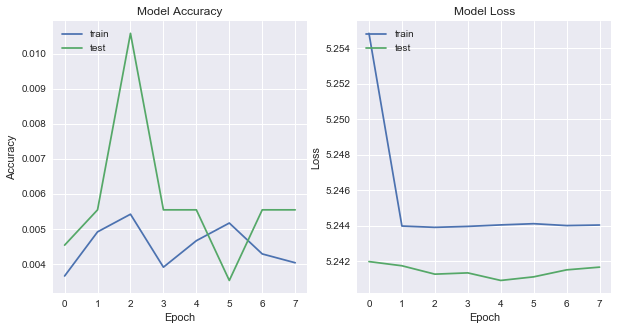

In [14]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['acc']), plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss']), plt.plot(history2.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Conv-Pool-Conv-Conv-Pool-Conv-Conv-Pool-Dropout)

In [15]:
model3 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = norm_x_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.30),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

lr_finder3 = ConvNet_sungil.lr_finder(model3)
lr_finder3.find(norm_x_train, y_train_bin, start_lr = 0.0001, end_lr = 1, batch_size = 128, epochs = 10)

Epoch 1/10
7938/7938 [==============================] - 312s 39ms/step - loss: 5.2418 - acc: 0.0055
Epoch 2/10
7938/7938 [==============================] - 322s 41ms/step - loss: 5.2394 - acc: 0.0071
Epoch 3/10
7938/7938 [==============================] - 329s 41ms/step - loss: 5.1705 - acc: 0.0106
Epoch 4/10
7938/7938 [==============================] - 314s 40ms/step - loss: 5.2403 - acc: 0.0047
Epoch 5/10
7938/7938 [==============================] - 310s 39ms/step - loss: 5.2459 - acc: 0.0044
Epoch 6/10
7938/7938 [==============================] - 322s 41ms/step - loss: 5.2489 - acc: 0.0042
Epoch 7/10
7938/7938 [==============================] - 315s 40ms/step - loss: 5.2575 - acc: 0.0044
Epoch 8/10
7938/7938 [==============================] - 319s 40ms/step - loss: 5.2794 - acc: 0.0039
Epoch 9/10
7938/7938 [==============================] - 320s 40ms/step - loss: 5.3394 - acc: 0.0045
Epoch 10/10
7938/7938 [==============================] - 309s 39ms/step - loss: 5.4727 - acc: 0.0037

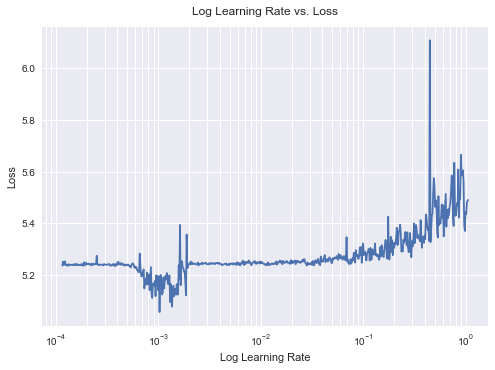

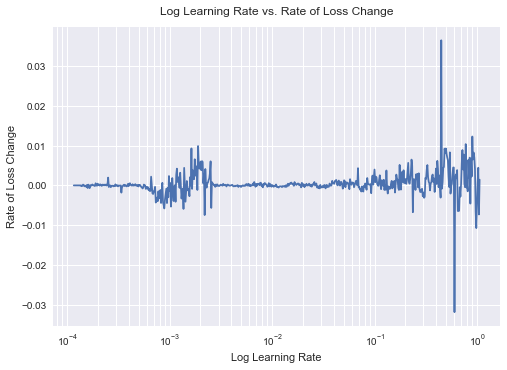

In [16]:
lr_finder3.plot_loss()
lr_finder3.plot_loss_change(sma = 20)

In [17]:
K.set_value(model3.optimizer.lr, 1.2*10**(-3))

# patient early stopping and model checkpoint
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = keras.callbacks.ModelCheckpoint('best_model3.h5', monitor = 'val_acc', mode = 'max',\
                                     verbose = 1, save_best_only = True)

# model fitting
start_ts = time.time()
history3 = model3.fit(norm_x_train, y_train_bin, batch_size = 128, epochs = 200,\
                      validation_data = (norm_x_test, y_test_bin),  callbacks = [es, mc])
print("Total Runtime:", time.time()-start_ts)

Train on 7938 samples, validate on 1985 samples
Epoch 1/200
7938/7938 [==============================] - 353s 44ms/step - loss: 5.2438 - acc: 0.0047 - val_loss: 5.2418 - val_acc: 0.0050

Epoch 00001: val_acc improved from -inf to 0.00504, saving model to best_model3.h5
Epoch 2/200
7938/7938 [==============================] - 354s 45ms/step - loss: 5.2430 - acc: 0.0057 - val_loss: 5.2418 - val_acc: 0.0045

Epoch 00002: val_acc did not improve from 0.00504
Epoch 3/200
7938/7938 [==============================] - 349s 44ms/step - loss: 5.2420 - acc: 0.0058 - val_loss: 5.2384 - val_acc: 0.0065

Epoch 00003: val_acc improved from 0.00504 to 0.00655, saving model to best_model3.h5
Epoch 4/200
7938/7938 [==============================] - 346s 44ms/step - loss: 5.1844 - acc: 0.0100 - val_loss: 5.1817 - val_acc: 0.0126

Epoch 00004: val_acc improved from 0.00655 to 0.01259, saving model to best_model3.h5
Epoch 5/200
7938/7938 [==============================] - 345s 43ms/step - loss: 5.1314 - ac

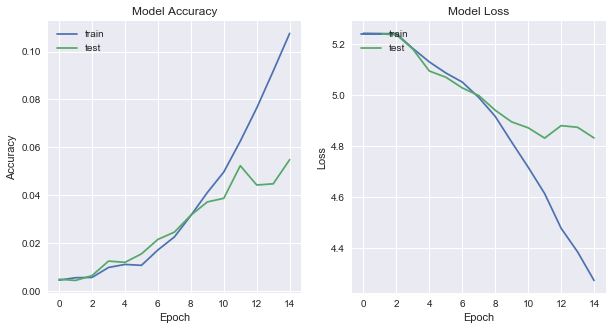

In [18]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['acc']), plt.plot(history3.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss']), plt.plot(history3.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()